In [1]:
import re, copy, pickle
from pathlib import Path

import spacy, pandas as pd
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore, LdaModel
import pyLDAvis as vis
import pyLDAvis.gensim_models as gensimvis

vis.enable_notebook()

# spacy internal setup
if not 'nlp' in locals():
    model_loaded: bool = False
    while not model_loaded:
        # we keep trying until this works...
        try:
            print("attempting to load model")
            # attempt to load the spacy model
            nlp: spacy.Language = spacy.load("en_core_web_sm")
            print("model loaded successfully")
            model_loaded = True
        except BaseException as e:
            print("model failed to load")
            # if we fail to load the model, we are going to make
            # sure the package is installed...
            from spacy.cli import download
            download("en_core_web_sm")
            # then loop around and try to load it again

C:\Users\Patrick\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


attempting to load model
model loaded successfully


In [2]:
path_root: Path = Path(".").resolve()
path_models: Path = Path("models")

In [3]:
md_text_raw: str = path_root.joinpath("moby_dick.txt").read_text('utf-8')

# Preprocess the text

In [4]:
# DEFINE SOME USEFUL VARIABLES FOR PREPROCESSING
# utf-8 codes for some characters in the text
dq_op: str = "\u201C" # double quotes open
dq_cl: str = "\u201D" # double quotes close
sq_op: str = "\u2018" # single quote open
sq_cl: str = "\u2019" # single quote close
under: str = "\u005F" # underscore
hyphe: str = "\u002D" # hyphen/minus
mdash: str = "\u2014" # em dash

In [5]:
# replace newlines and carriage returns with whitespace
md_text: str = re.sub(r"[\n\r]", " ", md_text_raw)
# remove everything before the first chapter
md_text = re.sub(r"[\w\W]*(?=CHAPTER 1\. Loomings)", "", md_text, count=1)
# remove everything after the end of the epilogue
md_text = re.sub(r"\s*(\*\*\* END)[\w\W]+", "", md_text, count=1)
# there are some weird embedded books in the middle of the text
# first we remove the in-betweens of the embedded books
md_text = re.sub(r"(Thus ends BOOK[\w\W]+?)([\w\W]+?BOOK[\w\W]+?)(?=\s\s)", "", md_text)
# then we get rid of the chapter headings of the embedded books
md_text = re.sub(r"BOOK\s+[IV]+([\w\W]+?(?=CHAPTER)CHAPTER\s+[IV\d]+\.\s+[\w\W]+?(?=\.)\.)?", "", md_text)
# CLEANING UP IMPORTANT UTF-8 CHARACTERS
# replace all utf single quotes with ascii single quotes
md_text = re.sub(f"{sq_op}|{sq_cl}", "\'", md_text)
# replace all utf double quotes with ascii double quotes
md_text = re.sub(f"{dq_op}|{dq_cl}", "\"", md_text)
# replace utf underscores with ascii
md_text = re.sub(f"{under}", "_", md_text)
# replace utf hyphens with ascii
md_text = re.sub(f"{hyphe}", "-", md_text)
# replace utf em dash with hyphen
md_text = re.sub(f"{mdash}", "-", md_text)
# next (and I don't know if this is a good idea...) we're going to replace
# all punctuation that is NOT a:
# . or ! or ? or whitespace or "
md_text = re.sub(r"[^\w\d\s\.\"?!]", " ", md_text)
# finally, we want to replace repeated whitespace with single whitespace
md_text = re.sub(r"\s+", " ", md_text)

In [6]:
# defining a function to contain intermediate variables
def split_chapters(text: str) -> dict[str, str]:
    # build a list of the chapter titles and their contents
    list_results: list[str] = [result.strip() for result in re.split(r"(CHAPTER\s\d+\.\s)|(Epilogue)", text) if result != "" and result is not None]
    # use that list to create a dictionary that is {chapter_title: chapter_content}
    return {x: list_results[i+1] for i, x in enumerate(list_results) if re.match(r"(CHAPTER\s\d+\.)|(Epilogue)", x)}
# run the processed text through the chapter splitter
dict_chapters: dict[str, str] = split_chapters(md_text)
#for i in dict_chapters:
    #print(i, dict_chapters[i])

In [7]:
# instantiate the spacy nlp object
# this object contains all of the functionality for
# turning a string or list of strings into spacy "Documents"
"""we no longer need to do the following line as it's loaded with the imports"""
# nlp: spacy.Language = spacy.load("en_core_web_sm")

# our book is a little too long for the default
# processing limit so we increase it slightly
nlp.max_length = 1200000

In [8]:
# let spacy process the full text
# this produces a "Document"
# the document is a tokenized representation of the full
# text with a bunch of extra information attached to the tokens
doc = nlp(md_text)

In [9]:
# spacy stores things like parts of speech as integer tags
# we can use this reverse lookup table to get the string label
lookup: dict[int, str] = {y: x for x, y in spacy.symbols.IDS.items()}

# Analyzing the number of nouns and verbs per chapter

hopefully, this reveals the "flow" of the story\
with more "intense" sections having higher noun and verb counts

we build a list of all things that are like nouns for the full text\
using pandas we build a series from the noun_alikes list\
that we can use to get the unique nouns and how many times they appear in the text

In [10]:
nounsPer = []
verbsPer = []
wordscount = []
verbscount = []
nounscount = []
verbsSum = 0
nounsSum = 0
k = 0

for ch in dict_chapters:
    #print(dict_chapters[ch])
    temp = nlp(dict_chapters[ch])
    wordscount.append(len(temp))
    
    noun_alikes:  list[str] = [x.text for x in temp if lookup[x.pos] in {"NOUN", "PROPN", "PRON"}]
    nouns: pd.Series = pd.Series(noun_alikes)
    nouns_counts: pd.Series = nouns.value_counts()
    n = (len(nouns_counts)/len(temp))*100
    nounsPer.append(n)
    nounscount.append(len(nouns_counts))
    #nounsSum += n
    #k += 1
    #avgNouns.append(nounsSum/k)
    
    verb_alikes:  list[str] = [x.text for x in temp if lookup[x.pos] in {"VERB", "ADVERB"}]
    verbs: pd.Series = pd.Series(verb_alikes)
    verbs_counts: pd.Series = verbs.value_counts()
    v = (len(verbs_counts)/len(temp))*100
    verbsPer.append(v)
    verbscount.append(len(verbs_counts))
    #print(nouns_counts)
    #print(len(nouns_counts))
    #verbsSum += v
    #avgVerbs.append(verbsSum/k)

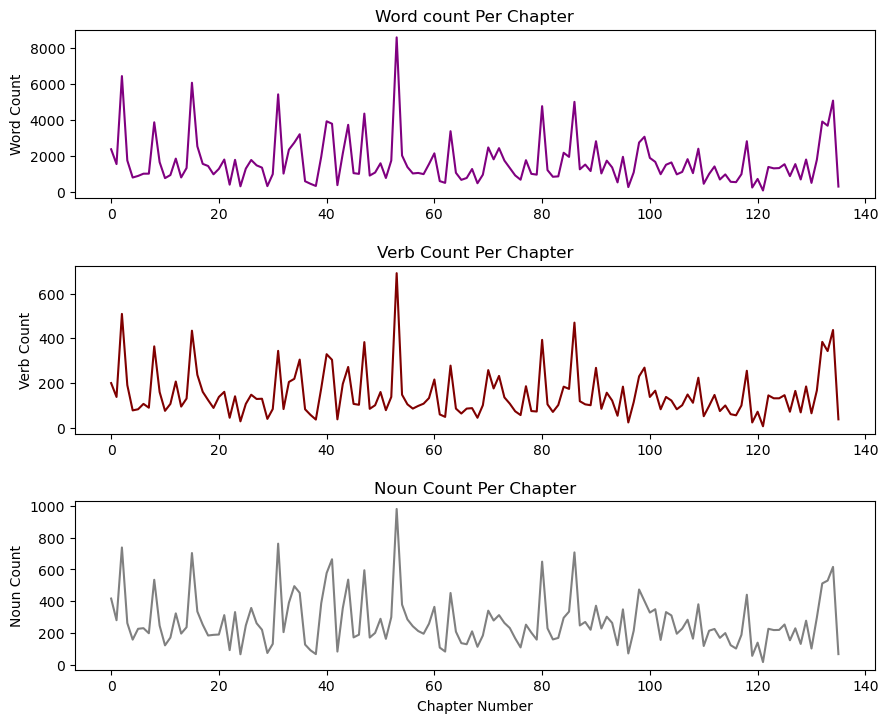

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
x = range(0,136)

plt.subplot(3, 1, 1)
plt.plot(x, wordscount, color ='purple')
#plt.xlabel('Chapter Number')
plt.ylabel('Word Count')
plt.title('Word count Per Chapter')

plt.subplot(3, 1, 2)

plt.plot(x, verbscount, color ='maroon')
#plt.xlabel('Chapter Number')
plt.ylabel('Verb Count')
plt.title('Verb Count Per Chapter')

plt.subplot(3, 1, 3)

plt.plot(x, nounscount, color ='grey')
plt.xlabel('Chapter Number')
plt.ylabel('Noun Count')
plt.title('Noun Count Per Chapter')
plt.show()

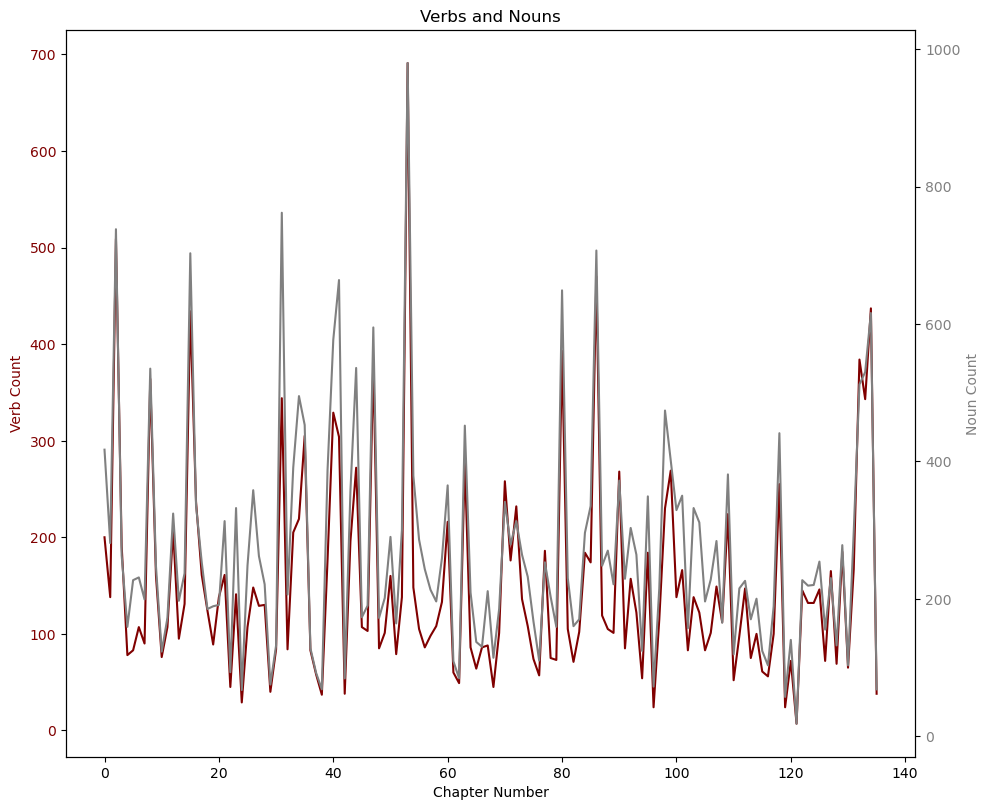

In [27]:
fig, ax1 = plt.subplots(figsize = (10, 8))

color = 'tab:red'
ax1.set_xlabel('Chapter Number')
ax1.set_ylabel('Verb Count', color='maroon')
ax1.plot(x, verbscount, color='maroon')
ax1.tick_params(axis='y', labelcolor='maroon')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Noun Count', color='grey')  # we already handled the x-label with ax1
ax2.plot(x, nounscount, color='grey')
ax2.tick_params(axis='y', labelcolor='grey')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Verbs and Nouns')
plt.show()

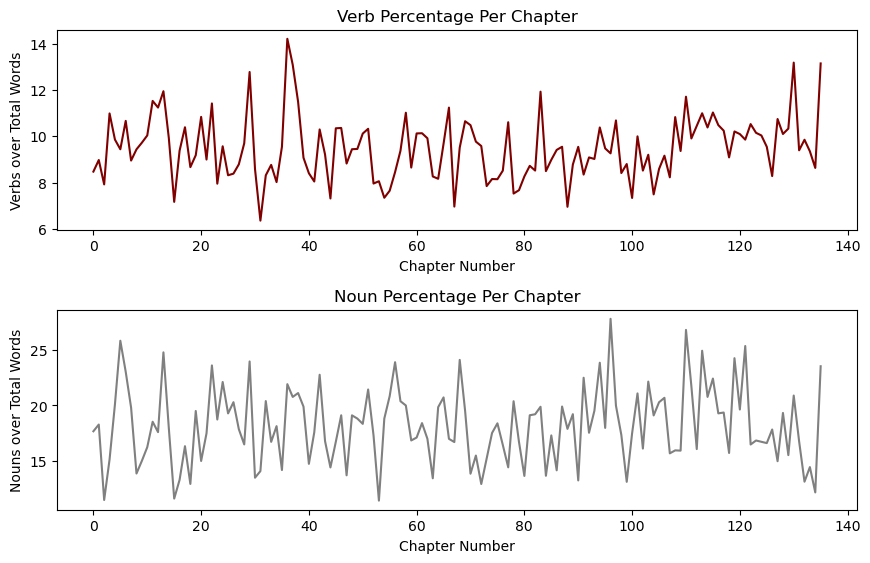

In [26]:
fig = plt.figure(figsize = (10, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



plt.subplot(2, 1, 1)
plt.plot(x, verbsPer, color ='maroon')
plt.xlabel('Chapter Number')
plt.ylabel('Verbs over Total Words')
plt.title('Verb Percentage Per Chapter')

plt.subplot(2, 1, 2)
plt.plot(x, nounsPer, color ='grey')
plt.xlabel('Chapter Number')
plt.ylabel('Nouns over Total Words')
plt.title('Noun Percentage Per Chapter')
plt.show()

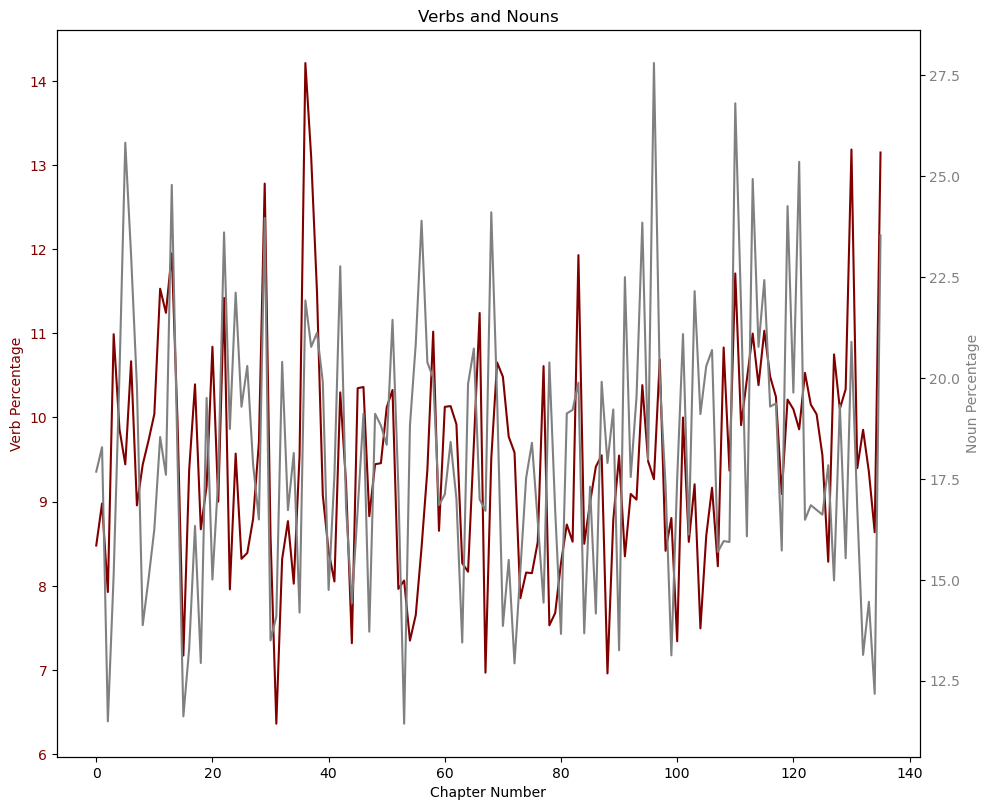

In [25]:
fig, ax1 = plt.subplots(figsize = (10, 8))

color = 'tab:red'
ax1.set_xlabel('Chapter Number')
ax1.set_ylabel('Verb Percentage', color='maroon')
ax1.plot(x, verbsPer, color='maroon')
ax1.tick_params(axis='y', labelcolor='maroon')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Noun Percentage', color='grey')  # we already handled the x-label with ax1
ax2.plot(x, nounsPer, color='grey')
ax2.tick_params(axis='y', labelcolor='grey')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Verbs and Nouns')
plt.show()

In [13]:
print("filtering tokens...")
# build a list of sentences broken into tokens
# cull punctuation and digit tokens as they shouldn't factor in here.
texts: list[list[str]] = [
    [
        token.lemma_ for token in sentence.as_doc() if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
    ]
    for sentence in doc.sents
]


print("building dictionary and corpus...")
# build the dictionary based on our texts
id2word = corpora.Dictionary(texts)
# using the dictionary, convert string tokens into numerical tokens
corpus = [id2word.doc2bow(text) for text in texts]

print("instantiate the model and analyze the text...")
# instantiate the model object
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)
# analyze the corpus
doc_lda = lda_model[corpus]

filtering tokens...
building dictionary and corpus...
instantiate the model and analyze the text...


In [14]:
gensimvis.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.404542  0.044667       1        1  11.673379
6      0.015872 -0.067422       2        1   8.446890
7      0.019307 -0.330134       3        1   6.926073
14     0.007417  0.002977       4        1   6.694325
5     -0.022607  0.024241       5        1   6.654207
8      0.008720 -0.000973       6        1   6.582739
16    -0.011499  0.022339       7        1   6.190299
15    -0.009834  0.021266       8        1   5.901165
4     -0.013210  0.023007       9        1   5.696151
1     -0.024847  0.024589      10        1   5.169904
18    -0.026808  0.024879      11        1   4.820772
10    -0.024456  0.024853      12        1   4.519722
11    -0.038242  0.024208      13        1   3.521772
19    -0.029032  0.024686      14        1   3.437778
12    -0.041823  0.023498      15        1   3.338617
13    -0.038131  0.024272      16        1   3.273792
9     -0.037354  0.024427      17        1   2.899195
17    -0.046555  0.021155      18        1   1.810308
3     -0.045655  0.021771      19        1   1.311669
0     -0.045804  0.021694      20        1   1.131245, topic_info=        Term         Freq        Total Category  logprob  loglift
52         s  5752.000000  5752.000000  Default  30.0000  30.0000
542    whale  2787.000000  2787.000000  Default  29.0000  29.0000
77       man  2507.000000  2507.000000  Default  28.0000  28.0000
124     like  1543.000000  1543.000000  Default  27.0000  27.0000
69      ship  1626.000000  1626.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
640    float     0.054079     2.556526  Topic20  -9.9169   0.6259
1154   lance     0.054077     2.556497  Topic20  -9.9170   0.6259
3876  Pequod     0.054077     2.556770  Topic20  -9.9170   0.6258
1556    bird     0.054076     2.556172  Topic20  -9.9170   0.6260
1354     cry     0.054076     2.558053  Topic20  -9.9170   0.6252

[861 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
349       7  0.990412    Captain
454       1  0.849138        New
25        4  0.957254    account
484       8  0.983360        act
114      17  0.922444  afternoon
...     ...       ...        ...
263      16  0.993746       wind
17        3  0.993222      world
18        2  0.992829       year
229       7  0.985326        yes
174      17  0.954440     yonder

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 8, 15, 6, 9, 17, 16, 5, 2, 19, 11, 12, 20, 13, 14, 10, 18, 4, 1])

# Analyzing topics of individual chapters

This is the same process as that for entire book text.\
\
The only difference is that we are iterating through the\
individual chapter texts and allowing spacy to process\
those.\
\
Additionally, we save these models to disk since they take a minute\
to prepare and we load them if they exist.

In [15]:
models: list[LdaModel] = []
corpii: list[list[tuple[int, int]]] = []
gsdicts: list[corpora.Dictionary] = []

for chap_num, chap_text in dict_chapters.items():
    
    print(f"processing {chap_num}")
    # if the model exists on disk, just load that
    path_model_out: Path = path_models.joinpath(chap_num.replace(" ", "").replace(".", ""))
    if path_model_out.exists():
        with open(path_model_out.joinpath("model.pickle"), 'rb') as file:
            models.append(pickle.load(file))
        with open(path_model_out.joinpath("corpus.pickle"), 'rb') as file:
            corpii.append(pickle.load(file))
        with open(path_model_out.joinpath("gsdict.pickle"), 'rb') as file:
            gsdicts.append(pickle.load(file))
        continue
    
    doc = nlp(chap_text)
    
    texts: list[list[str]] = [
        [
            token.lemma_ for token in sentence.as_doc() if
            not token.is_stop
            and not token.is_punct
            and not token.is_digit
        ]
        for sentence in doc.sents
    ]
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=20, 
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    doc_lda = lda_model[corpus]
    
    models.append(copy.copy(lda_model))
    corpii.append(copy.copy(corpus))
    gsdicts.append(copy.copy(id2word))
    pass

processing CHAPTER 1.
processing CHAPTER 2.
processing CHAPTER 3.
processing CHAPTER 4.
processing CHAPTER 5.
processing CHAPTER 6.
processing CHAPTER 7.
processing CHAPTER 8.
processing CHAPTER 9.
processing CHAPTER 10.
processing CHAPTER 11.
processing CHAPTER 12.
processing CHAPTER 13.
processing CHAPTER 14.
processing CHAPTER 15.
processing CHAPTER 16.
processing CHAPTER 17.
processing CHAPTER 18.
processing CHAPTER 19.
processing CHAPTER 20.
processing CHAPTER 21.
processing CHAPTER 22.
processing CHAPTER 23.
processing CHAPTER 24.
processing CHAPTER 25.
processing CHAPTER 26.
processing CHAPTER 27.
processing CHAPTER 28.
processing CHAPTER 29.
processing CHAPTER 30.
processing CHAPTER 31.
processing CHAPTER 32.
processing CHAPTER 33.
processing CHAPTER 34.
processing CHAPTER 35.
processing CHAPTER 36.
processing CHAPTER 37.
processing CHAPTER 38.
processing CHAPTER 39.
processing CHAPTER 40.
processing CHAPTER 41.
processing CHAPTER 42.
processing CHAPTER 43.
processing CHAPTER 4

# DUMP THE MODELS TO DISK IF WE ARE RE-EVALUATING

In [16]:
# for i, chap in enumerate(dict_chapters.keys()):
#     path_chap: Path = path_models.joinpath(chap.replace(" ", "").replace(".", ""))
#     path_chap.mkdir(parents=True, exist_ok=True)
#     path_file_model: Path = path_chap.joinpath("model.pickle")
#     path_file_corpus: Path = path_chap.joinpath("corpus.pickle")
#     path_file_gsdict: Path = path_chap.joinpath("gsdict.pickle")
#     with open(path_file_model, 'wb') as file:
#         pickle.dump(models[i], file)
#     with open(path_file_corpus, 'wb') as file:
#         pickle.dump(corpii[i], file)
#     with open(path_file_gsdict, 'wb') as file:
#         pickle.dump(gsdicts[i], file)

In [17]:
len(dict_chapters)

136

In [18]:
index_chapter: int = 134
gensimvis.prepare(
    models[index_chapter], 
    corpii[index_chapter], 
    gsdicts[index_chapter]
)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.168834 -0.249628       1        1  13.345264
17     0.077610 -0.051078       2        1  10.201227
19    -0.147809 -0.070314       3        1   9.673468
5     -0.295621 -0.157870       4        1   8.943175
16    -0.003365  0.075833       5        1   5.724228
6      0.019724 -0.005963       6        1   5.541786
7      0.080632 -0.047644       7        1   4.844443
11    -0.012115  0.049903       8        1   4.656914
10     0.001379  0.058150       9        1   4.647237
12    -0.000248  0.067478      10        1   4.551960
14     0.035246  0.013369      11        1   4.493537
15    -0.001947  0.076032      12        1   4.469867
9     -0.016515  0.084626      13        1   4.144705
8      0.004556  0.050180      14        1   3.806911
0      0.001822  0.046506      15        1   3.293817
18     0.076492 -0.076199      16        1   3.176432
4      0.003541  0.038614      17        1   1.843964
2      0.002882  0.036067      18        1   1.573817
13     0.002431  0.032699      19        1   0.586607
1      0.002471  0.029241      20        1   0.480640, topic_info=         Term       Freq      Total Category  logprob  loglift
93       ship  59.000000  59.000000  Default  30.0000  30.0000
278     round  36.000000  36.000000  Default  29.0000  29.0000
163       sea  51.000000  51.000000  Default  28.0000  28.0000
20       Ahab  47.000000  47.000000  Default  27.0000  27.0000
19       spar  28.000000  28.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
18   solitary   0.010255   1.263364  Topic20  -6.9542   0.5241
19       spar   0.010255  28.398639  Topic20  -6.9542  -2.5885
20       Ahab   0.010255  47.685512  Topic20  -6.9542  -3.1068
21        cry   0.010255   8.316074  Topic20  -6.9542  -1.3604
22          d   0.010255   2.918483  Topic20  -6.9542  -0.3132

[795 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
20        1  0.377473      Ahab
20        2  0.083883      Ahab
20        7  0.419415      Ahab
20       11  0.104854      Ahab
0        11  0.708122     Chase
...     ...       ...       ...
299       3  0.643462  windward
315      13  0.948531      wood
42        8  0.518288     world
42       13  0.518288     world
25       11  0.968446        ye

[283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 18, 20, 6, 17, 7, 8, 12, 11, 13, 15, 16, 10, 9, 1, 19, 5, 3, 14, 2])

# Analysis and Discussion